In [4]:
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.integrate as integrate
from scipy.signal import find_peaks

In [5]:
#Milky Way constants:
#Milky Way rho_0 in Msol/pc^3 (Abarca http://www.vixra.org/pdf/1606.0007v1.pdf)
rho_0_MW = 12.1e-3
#Milky Way R_s in pc
R_s_MW = 14.4e3
#Milky Way mass (only needed if not using NFW calculation)
M_MW= 5e14


# constants
G          = 0.004491 #pc^3/Msol/Ma^2
M_sat      = 1e6 #mass of the perturbing satellite
m_field    = 1e0 #mass of the field particle
log_lambda = 15 #Coulomb Logarithm
c          = 10 #concentration parameter
sigma      = 200 #pc/Ma velocity dispersion



# Defines the density distribution of an NFW Profile
def NFW_Profile(R, R_s = R_s_MW):
    return R / (1 + R/R_s)**2

# Gives the total mass of an NFW-halo within Radius R
def NFW_Mass(R, rho_0=rho_0_MW, R_s=R_s_MW):   
    M = 4*np.pi*rho_0*R_s* integrate.romberg(NFW_Profile, 0, R, divmax = 6)
    return M

# Defines the denstity distribution of a Hernquist Profile
def Hernquist_Profile(R, A = 2e4, M = 1e12):
    return M * A / (2 * np.pi * R * (R + A)**3)

# Gives the total mass of a Hernquits Halo within Radius R
def Hernquist_Mass(R, A = 2e4, M = 1e12):
    return M * R**2 / (R + A)**2

# Gives radial acceleration due to a mass M
def Grav_Acceleration(M, R):
    G = 0.004491 #pc^3/Msol/Ma^2
    return -M * G / R**2

In [15]:
print(np.sqrt(G * Hernquist_Mass(80000) / 80000))

189.54682798717576


In [6]:
# DF for an NFW profile
# constants
v        = 178
r_v      = 1e5 # virial radius
G        = 0.004491 # pc^3/Msol/Ma^2
rho_crit = 1.478e-7 # Msol/pc^3

# derived quantities
M_v = 4/3 * np.pi * r_v**3 * v * rho_crit
V_v_squared = G * M_v / r_v
rho_c0      = M_v / (4. / 3. * np.pi * r_v**3 * v)



# general function definitions

def g(c):
    return 1. / (np.log(1.+c) - c / (1. + c))

def psi_bar(s,c):
    return np.log(1 + c*s) / s

def rho_bar(s,c):
    return 1. / (s * (1. + c*s)**2)

def C_1(c):
    return g(c) * V_v_squared

def C_2(c):
    return c**2 * g(c) * M_v / (4. * np.pi * r_v**3)

def psi(s,c):
    return psi_bar(s,c) * C_1(c)

def rho(s,c):
    return rho_bar(s,c) * C_2(c)
    
def s_apx(psi_normalized, c):
    return -1.75 * np.log(psi_normalized / c) / psi_normalized

def drho_ds(s,c):
    return (-3. * c * s - 1.) / (s**2 * (1. + c*s)**3)

def dpsi_ds(s,c):
    return (c*s / (1 + c*s) - np.log(1. + c*s)) / s**2

def drho_dpsi(s,c):
    return drho_ds(s,c) / dpsi_ds(s,c)

def ddrho_dpsids(s,c):
    cs = c * s
    cs_1 = cs + 1
    return (
            -c*cs * (-3.*cs + 6.*cs_1*np.log(cs_1) + 1.) / 
             (cs_1**3 * (cs - cs_1 * np.log(cs_1))**3)        
           )

def ddrho_dpsidpsi(s,c):
    return ddrho_dpsids(s,c) / dpsi_ds(s,c)


# distribution functions
def NFWenergyDF(eps,c):
    integralFunction = lambda psi: C_2(c) / C_1(c) * ddrho_dpsidpsi(s_apx(psi / C_1(c), c),c) / np.sqrt(eps - psi)
    return 1. / (np.sqrt(8.) * np.pi**2) * integrate.romberg(integralFunction, 1, eps-1,divmax=10)

def NFWvelocityDF(v, c):
    epsilon = .5 * v**2 # kinetic energy per mass
    #print(epsilon)
    return NFWenergyDF(epsilon, c)

In [7]:
# DF for a Hernquist Profile
G        = 0.004491 # pc^3/Msol/Ma^2

def q(E,A,M):
    return (-A * E / (G * M))**.5
    
def v_g(M, A):
    return (G * M / A)**.5
    
def Hernquist_Energy_DF(E, A, M):
    q_H = q(E,A,M)
    return (
            M / (8. * np.sqrt(2.) * np.pi**3 * A**3 * v_g(M, A)**3 * (1. - q_H**2)**2.5)
            * ( 3. * np.arcsin(q_H) + 
                q_H * (1. - q_H**2)**.5 * (1. - 2. * q_H**2) * (8. * q_H**4 - 8 * q_H**2 - 3.)
              )
            )

def Hernquist_Velocity_DF(v, M_interior, R, A = 2e4, M = 1e12):
    E = -.5 * v**2 #+ G * M_sat / R # kinetic energy per mass
    return Hernquist_Energy_DF(E, A, M)

# Maxwellian as an approximate velocity DF

def X_maxwell(v_M, sigma):
    return v_M / (np.sqrt(2) * sigma)

def Maxwellian(v_M, sigma):
    X = X_maxwell(v_M, sigma)
    return math.erf(X) - 2 * X / np.sqrt(np.pi) * np.exp(-X**2)

def Chandrasekhar_Maxwellian(velocity_i, velocity_not_i, M_sat, R, sigma):
    v = (velocity_i**2 + velocity_not_i**2)**.5
    
    return - 4 * G**2 * M_sat * Hernquist_Profile(R) * log_lambda / v**3 * Maxwellian(v, sigma)

In [8]:
# acceleration due to dynamical friction

#Chandrasekhar Constant Prefactor
def ChandraConstant(m, M):
    return -16. * np.pi**2 * G**2 * m * (M + m) * log_lambda


# Chandrasekhars Formula (accepts v = [v_x, v_y] as input and outputs a = [a_x, a_y])
def Chandrasekhar(velocity_i, velocity_not_i, M_interior, R):
    v = (velocity_i**2 + velocity_not_i**2)**.5
    integralFunction = lambda v_a: v_a**2 * Hernquist_Velocity_DF(v_a, M_interior, R)
    
    return ChandraConstant(m_field, M_sat) * integrate.romberg(integralFunction, 0, v, divmax=10) / v**3 * velocity_i

In [30]:
# Leapfrog Algorithm:
def Leapfrog_Cartesian(n, t, X_0, Y_0, rho_0, R_s, X_dot_0=0, Y_dot_0=0):
    
    G = 0.004491 # pc^3/Msol/Ma^2

    #S etup of the primary variables
    X = np.zeros(n)
    X_dot = np.zeros(n)
    X_dotdot = np.zeros(n)
    Y = np.zeros(n)
    Y_dot = np.zeros(n)
    Y_dotdot = np.zeros(n)
    
    # Setup of the secondary variables
    R = np.zeros(n)
    PHI = np.zeros(n)
    PHI_dot = np.zeros(n)
    
    # Setup of variables used for debugging
    M = np.zeros(n)
    V = np.zeros(n)
    U = np.zeros(n)
    E = np.zeros(n)
    L = np.zeros(n)
    Dynamical_Friction = np.zeros(n)

    
    # Initial values
    X[0] = X_0
    Y[0] = Y_0
    X_dot[0] = X_dot_0
    Y_dot[0] = Y_dot_0
    
    R[0] = (X[0]**2 + Y[0]**2)**.5
    PHI[0] = math.atan2(Y[0], X[0])
    
    X_dotdot[0] = Grav_Acceleration(M[0], R[0]) * np.cos(PHI[0])
    Y_dotdot[0] = Grav_Acceleration(M[0], R[0]) * np.sin(PHI[0])
    
    M[0]= Hernquist_Mass(R[0])
    V[0] = (X_dot[0]**2 + Y_dot[0]**2) * .5
    U[0] = - G * M[0] / R[0]
    E[0] = V[0] + U[0]
    L[0] = R[0]**2 * PHI_dot[0]
    
    X_dot_now = X_dot[0] + X_dotdot[0] * t
    Y_dot_now = Y_dot[0] + Y_dotdot[0] * t
    Chandra_X = Chandrasekhar_Maxwellian(X_dot_now, Y_dot_now, M_sat, R[0], sigma)
    Chandra_Y = Chandrasekhar_Maxwellian(Y_dot_now, X_dot_now, M_sat, R[0], sigma)
    Dynamical_Friction[0] = (Chandra_X**2 + Chandra_Y**2)**.5
    print(Dynamical_Friction[0])


    
    for i in range(1, n):
        
        # computes the current primary positions
        X[i] = X[i-1] + X_dot[i-1] * t + .5 * X_dotdot[i-1] * t**2
        Y[i] = Y[i-1] + Y_dot[i-1] * t + .5 * Y_dotdot[i-1] * t**2
        
        # and secondary positions
        PHI[i] = math.atan2(Y[i], X[i])
        R[i] = (X[i]**2 + Y[i]**2)**.5
        
        # computes the current mass inside the radius
        M[i]= Hernquist_Mass(R[i])
        
        # approximate the speed at the current timestep
        X_dot_now = X_dot[i-1] + X_dotdot[i-1] * t
        Y_dot_now = Y_dot[i-1] + Y_dotdot[i-1] * t
        
        # Dynamical Friction Acceleration
        Chandra_X = Chandrasekhar_Maxwellian(X_dot_now, Y_dot_now, M_sat, R[i], sigma)
        Chandra_Y = Chandrasekhar_Maxwellian(Y_dot_now, X_dot_now, M_sat, R[i], sigma)
        
        # computes the current acceleration
        X_dotdot[i] = Grav_Acceleration(M[i], R[i]) * np.cos(PHI[i]) + Chandra_X
        Y_dotdot[i] = Grav_Acceleration(M[i], R[i]) * np.sin(PHI[i]) + Chandra_Y
        
        # computes the current velocity
        X_dot[i] = X_dot[i-1] + .5 * (X_dotdot[i-1] + X_dotdot[i]) * t
        Y_dot[i] = Y_dot[i-1] + .5 * (Y_dotdot[i-1] + Y_dotdot[i]) * t
        
        # computes the debugging variables
        PHI_dot[i] = (PHI[i] - PHI[i-1]) / t
        V[i] = (X_dot[i]**2 + Y_dot[i]**2) * .5
        U[i] = - G * M[i] / R[i]
        E[i] = V[i] + U[i]
        L[i] = R[i]**2 * PHI_dot[i]
        Dynamical_Friction[i] = (Chandra_X**2 + Chandra_Y**2)**.5
        
        
                    
    return X, Y, R, PHI, E, V, U, M, L, X_dot, Y_dot, Dynamical_Friction

8.338490552252601e-10


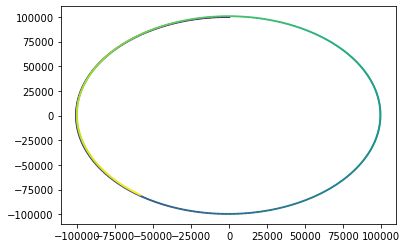

In [31]:
#Cartesian Plotting

#SagDEG initial coordinates
X_0 = 0.1
Y_0 = 1e5
X_dot_0 = -np.sqrt(G * Hernquist_Mass(Y_0) / Y_0)
Y_dot_0 = 1

n = 1000
t = 5

#Plots the coordinates
X, Y, R, PHI, E, V, U, M, L, X_dot, Y_dot, Dynamical_Friction = Leapfrog_Cartesian(n, t, X_0, Y_0, rho_0_MW, R_s_MW, X_dot_0, Y_dot_0)
t = np.arange(0, n)


plt.scatter(X, Y, 1, t)

#plt.plot(t, coordinates[2])


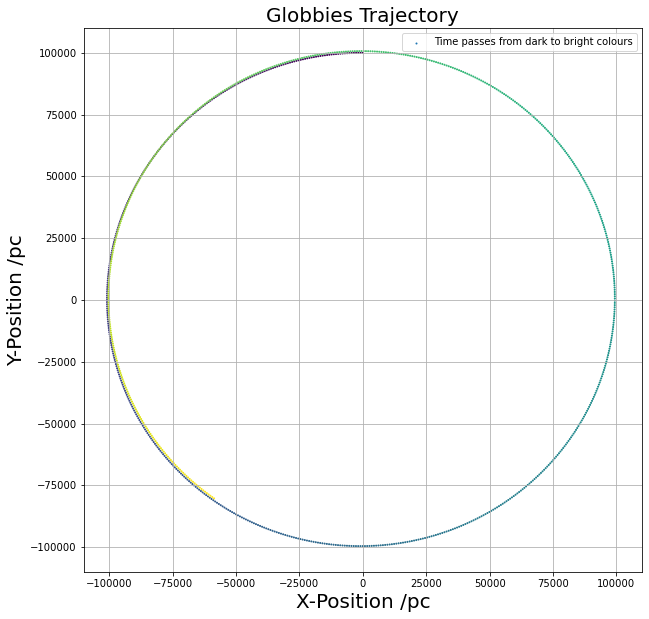

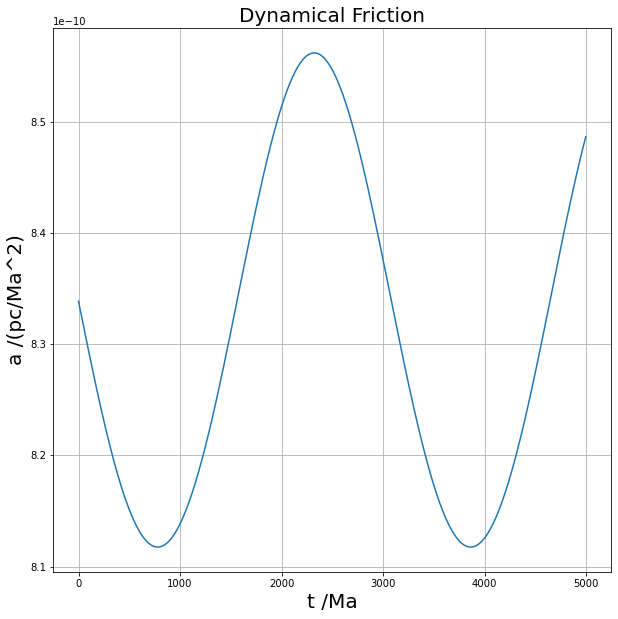

In [38]:
plt.figure(figsize=(10, 10))
plt.scatter(X, Y, 1, t, label='Time passes from dark to bright colours')
plt.title('Globbies Trajectory', fontsize=20)
plt.xlabel('X-Position /pc', fontsize=20)
plt.ylabel('Y-Position /pc', fontsize=20)
plt.legend()
plt.xlim(-1.1e5, 1.1e5)
plt.ylim(-1.1e5, 1.1e5)
plt.grid()
plt.savefig('GlobbyPositionHernquist.png')

t = np.arange(0, n)
plt.figure(figsize=(10, 10))
#plt.plot(t, -E*1e-3, label='E')
#plt.plot(t, V*1e-3, label='V')
#plt.plot(t, -U*1e-3, label='U')
#plt.plot(t, R/np.amax(R), label='R')
plt.plot(t*5, Dynamical_Friction, Label='Dynamical Friction')
#plt.plot(t, Dynamical_Friction/np.amax(Dynamical_Friction), Label='Dynamical Friction')

plt.title('Dynamical Friction', fontsize=20)
plt.xlabel('t /Ma', fontsize=20)
plt.ylabel('a /(pc/Ma^2)', fontsize=20)
plt.grid()
plt.savefig('DynamicalFrictionvsTimeHernquist.png')
#plt.yscale('log')
#plt.xscale('log')

#plt.legend()
#plt.savefig('Radius.png')

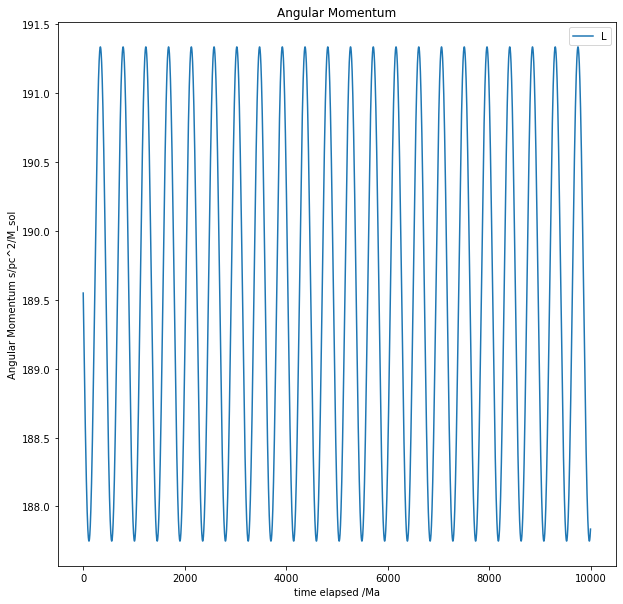

In [19]:

for i in range(n):
    if L[i] <= 0:
        L[i] = float('NaN')
        

plt.figure(figsize=(10,10))
plt.plot(t, (X_dot**2 + Y_dot**2)**.5, label='L')
plt.title('Angular Momentum')
plt.xlabel('time elapsed /Ma')
plt.ylabel('Angular Momentum s/pc^2/M_sol')
plot_diff = 1e8
#plt.ylim([1-plot_diff, 1 + plot_diff])
plt.legend()
plt.savefig('angular-momentum-double-steps.png')

[156 772]


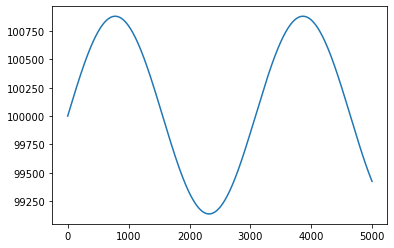

In [26]:
t_range = np.linspace(0, n-1, n)

t_max, _ = find_peaks(R)
print(t_max)
peaks = np.zeros(len(t_max))
for i in range(len(t_max)):
    peaks[i] = R[t_max[i]]
    
plt.plot(t_range*5, R)